In [2]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import random

%matplotlib inline

In [3]:
# Always reset the pseudo random number generator to the same number.
seed = 42
np.random.seed(seed)
random.seed(seed)

In [4]:
# Define the number of examples.
N = 1000

# Features.
x1 = 3.0 * np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = x1 + x2

# Observable model.
y_noisy = y + w

In [5]:
# Generate values for parameters.
M = 200
a1 = np.linspace(-12.0, 14.0, M)
a2 = np.linspace(-12.0, 14.0, M)

A1, A2 = np.meshgrid(a1, a2)

# Generate points for plotting the cost-function surface.
J = np.zeros((M,M))
for iter1 in range(0, M):
    for iter2 in range(0, M):
        yhat = A1[iter1][iter2]*x1 + A2[iter1][iter2]*x2
        J[iter1][iter2] = (1.0/N)*np.sum(np.square(y_noisy - yhat))

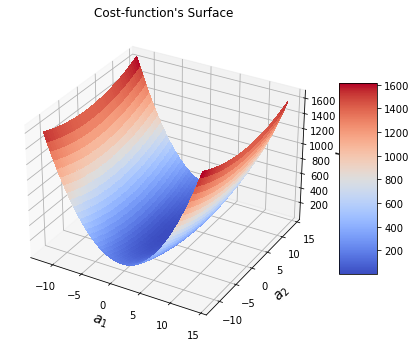

In [6]:
# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
plt.savefig("error_surface_sgd_vs_mom.png", dpi=600)
#Show the plot.
plt.show()

In [7]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Closed-form solution.
a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

yhat = X.dot(a_opt)
Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))

print('Joptimum:',Joptimum)

Joptimum: 0.9656766303811873


In [7]:
class SGD():
    
    a = 0
    Jgd = 0
    a_hist = 0
    update_hist = 0
    
    def __init__(self, updateType='conv', N=1000, K=2, n_epochs=1000, alpha=0.01, a_init=[0,0], seed=42, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.updateType = updateType
        self.seed = seed
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.alpha = alpha
        self.n_epochs = n_epochs
        self.N = N
        self.inc = 0
        self.K = K
        self.a = np.array(a_init).reshape(self.K, 1)
        # Create empty structures.
        self.m_da = np.zeros((self.K,))
        self.v_da = np.zeros((self.K,))
        self.a_hist = np.zeros((K, n_epochs*N+1))
        self.Jgd = np.zeros(n_epochs*N+1)    
        self.update_hist = np.zeros((K, n_epochs*N))
        # Initialize history.
        self.a_hist[:,0] = self.a.reshape(self.K,)
        
    def __update__(self, inc, a, grad):
        if(self.updateType == 'adam'):
            return self.__adamUpdate__(inc, a, grad)
        else:
            return self.__convUpdate__(inc, a, grad)
        
    # Conventional update.
    def __convUpdate__(self, inc, a, grad):
     
        # Update weights.
        update = self.alpha*grad
        a = a - update
        
        # Keep update history.
        self.update_hist[:, inc] = update.reshape(self.K,)
        
        return a

    # Adam-based update.
    def __adamUpdate__(self, inc, a, grad):
        
        m_da_corr = np.zeros((self.K,))
        v_da_corr = np.zeros((self.K,))
        
        for k in range(self.K):

            # grad is from current iteration.
            # momentum beta 1
            self.m_da[k] = self.beta1*self.m_da[k] + (1.0-self.beta1)*grad[k,0]

            # rms beta 2
            self.v_da[k] = self.beta2*self.v_da[k] + (1.0-self.beta2)*(grad[k,0]**2)

            # bias correction
            m_da_corr[k] = self.m_da[k]/(1.0-self.beta1**(inc+1))
            v_da_corr[k] = self.v_da[k]/(1.0-self.beta2**(inc+1))

            # Update weights.
            update = self.alpha*(m_da_corr[k]/(np.sqrt(v_da_corr[k]+self.epsilon)))
            a[k,0] = a[k,0] - update
        
            # Keep update history.
            self.update_hist[k, inc] = update 
        
        return a
    
    def getParams(self):
        return self.a, self.Jgd, self.a_hist, self.update_hist 
    
    def fit(self, X, y_noisy):
        
        # Reset PN generator.
        random.seed(self.seed)
        
        # calculate initial error.
        self.Jgd[0] = (1.0/self.N)*sum(np.power(y_noisy - X.dot(self.a), 2))
        
        # Stocastic gradient-descent loop.
        for epoch in range(self.n_epochs):

            # Shuffle the whole dataset before every epoch.
            shuffled_indexes = random.sample(range(0, self.N), self.N)  

            for i in range(self.N):
                # Randomly draw samples from dataset.
                rand_ind = shuffled_indexes[i]
                xi = X[rand_ind:rand_ind+1]
                yi = y_noisy[rand_ind:rand_ind+1]
                
                # Calculate gradient vector.
                grad = -2.0*xi.T.dot(yi - xi.dot(self.a)) 
                
                # Calculate update parameters.
                self.a = self.__update__(self.inc, self.a, grad)

                # Calculate error.
                self.Jgd[self.inc+1] = (1.0/self.N)*sum(np.power(y_noisy - X.dot(self.a), 2))
                
                # Keep history.
                self.a_hist[:, self.inc+1] = self.a.reshape(self.K,)               
                
                # Increment interation counter.
                self.inc += 1

# Pure SGD

In [8]:
# Number of epochs.
n_epochs = 1
# Learning rate.
alpha = 0.02
# Number of features.
K = 2
# Initial weights.
a_init = [-10.0, -10.0]
# Update type.
updateType = 'conv'

# Instantiate traditional SGD.
sgd = SGD(updateType, N, K, n_epochs, alpha, a_init, seed)

# Train traditional SGD.
sgd.fit(X, y_noisy)

# Retrieve parameters.
a_conv, Jgd, a_hist, update_hist = sgd.getParams()

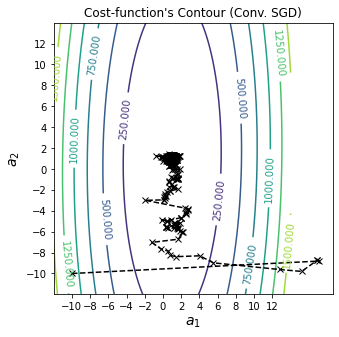

In [9]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour (Conv. SGD)')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-10, 14, step=2.0))
plt.yticks(np.arange(-10, 14, step=2.0))
plt.savefig('contourn_conv.png', dpi=600)
plt.show()

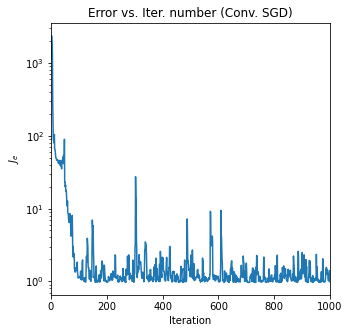

In [10]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.arange(0, n_epochs*N), Jgd[0:n_epochs*N])
plt.xlim((0, n_epochs*N))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iter. number (Conv. SGD)')
plt.savefig('error_conv.png', dpi=600)
plt.show()

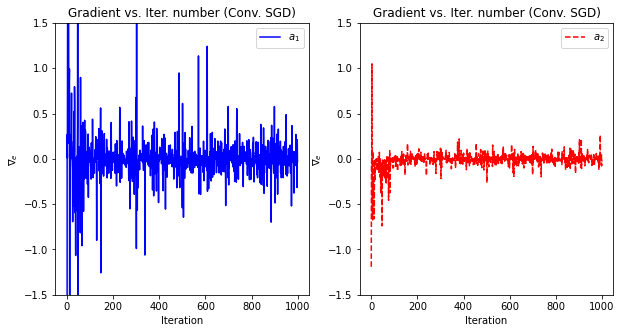

In [11]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'b', label='$a_1$')
ax1.set_ylim([-1.5, 1.5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number (Conv. SGD)')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, n_epochs*N), update_hist[1,:], 'r--', label='$a_2$')
ax2.set_ylim([-1.5, 1.5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number (Conv. SGD)')
ax2.legend()

plt.savefig('grad_conv.png', dpi=600)
plt.show()

# Adam-based SGD

In [12]:
# Number of epochs.
n_epochs = 1
# Learning rate.
alpha = 0.3
# Number of features.
K = 2
# Initial weights.
a_init = [-10.0, -10.0]
# Adam parameters.
updateType = 'adam'
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Instantiate Adam-based SGD.
sgd = SGD(updateType, N, K, n_epochs, alpha, a_init, seed, beta1, beta2, epsilon)

# Train Adam-based SGD.
sgd.fit(X, y_noisy)

# Retrieve parameters.
a_adam, Jgd, a_hist, update_hist = sgd.getParams()

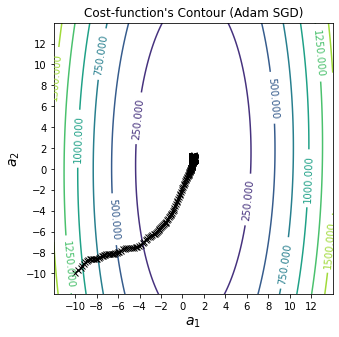

In [13]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour (Adam SGD)')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-10, 14, step=2.0))
plt.yticks(np.arange(-10, 14, step=2.0))
plt.savefig('contourn_adam.png', dpi=600)
plt.show()

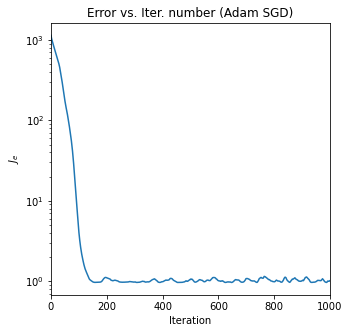

In [14]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.arange(0, n_epochs*N), Jgd[0:n_epochs*N])
plt.xlim((0, n_epochs*N))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iter. number (Adam SGD)')
plt.savefig('error_adam.png', dpi=600)
plt.show()

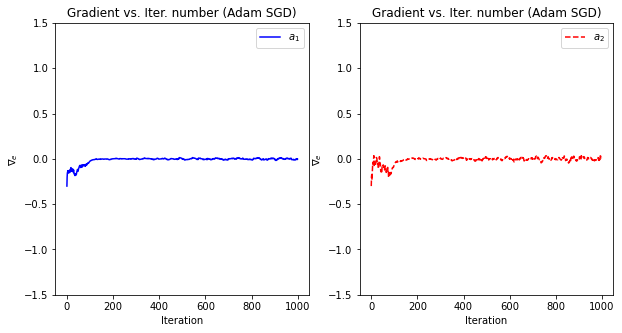

In [15]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, n_epochs*N), update_hist[0,:], 'b', label='$a_1$')
ax1.set_ylim([-1.5, 1.5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number (Adam SGD)')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, n_epochs*N), update_hist[1,:], 'r--', label='$a_2$')
ax2.set_ylim([-1.5, 1.5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number (Adam SGD)')
ax2.legend()

plt.savefig('grad_adam.png', dpi=600)
plt.show()